# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shapiq

shapiq.__version__

'1.2.3.9000'

### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.7990
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 0.0,
 (0,): 0.07142665791343267,
 (1,): -0.0928775739395707,
 (2,): -0.022483413439042442,
 (3,): 0.011940203370314269,
 (4,): 0.013915113683489274,
 (5,): -0.181543043541707,
 (6,): 0.1659354571367876,
 (7,): -0.2739059009240897,
 (0, 1): -0.050341103351389645,
 (0, 2): 0.004409889320134275,
 (0, 3): -0.018724390699627128,
 (0, 4): -0.010566836164876728,
 (0, 5): -0.09813749218787719,
 (0, 6): -0.0657000514290866,
 (0, 7): 0.040594309096797496,
 (1, 2): -0.00656194644954789,
 (1, 3): -0.00845616191745713,
 (1, 4): -0.01178250265156163,
 (1, 5): 0.13356862746218368,
 (1, 6): -0.010910681191298947,
 (1, 7): -0.016084648325231238,
 (2, 3): -0.01843720675123119,
 (2, 4): -0.011581075522974417,
 (2, 5): -0.017273628078511186,
 (2, 6): -0.008070064386308293,
 (2, 7): -0.016116286558418402,
 (3, 4): -0.011873194384584715,
 (3, 5): -0.007724081428726512,
 (3, 6): -0.01288056087636383,
 (3, 7): -0.012661102232475236,
 (4, 5): -0.021686298322321464,
 (4, 6): -0.012357283899639634,
 (4, 7):

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.050341103351389645,
 (0, 2): 0.004409889320134275,
 (0, 3): -0.018724390699627128,
 (0, 4): -0.010566836164876728,
 (0, 5): -0.09813749218787719,
 (0, 6): -0.0657000514290866,
 (0, 7): 0.040594309096797496,
 (1, 2): -0.00656194644954789,
 (1, 3): -0.00845616191745713,
 (1, 4): -0.01178250265156163,
 (1, 5): 0.13356862746218368,
 (1, 6): -0.010910681191298947,
 (1, 7): -0.016084648325231238,
 (2, 3): -0.01843720675123119,
 (2, 4): -0.011581075522974417,
 (2, 5): -0.017273628078511186,
 (2, 6): -0.008070064386308293,
 (2, 7): -0.016116286558418402,
 (3, 4): -0.011873194384584715,
 (3, 5): -0.007724081428726512,
 (3, 6): -0.01288056087636383,
 (3, 7): -0.012661102232475236,
 (4, 5): -0.021686298322321464,
 (4, 6): -0.012357283899639634,
 (4, 7): -0.011460704903962726,
 (5, 6): -0.022349747645455654,
 (5, 7): 0.012221470015281243,
 (6, 7): -0.0506954942373288}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 0.        , -0.0503411 ,  0.00440989, -0.01872439, -0.01056684,
        -0.09813749, -0.06570005,  0.04059431],
       [-0.0503411 ,  0.        , -0.00656195, -0.00845616, -0.0117825 ,
         0.13356863, -0.01091068, -0.01608465],
       [ 0.00440989, -0.00656195,  0.        , -0.01843721, -0.01158108,
        -0.01727363, -0.00807006, -0.01611629],
       [-0.01872439, -0.00845616, -0.01843721,  0.        , -0.01187319,
        -0.00772408, -0.01288056, -0.0126611 ],
       [-0.01056684, -0.0117825 , -0.01158108, -0.01187319,  0.        ,
        -0.0216863 , -0.01235728, -0.0114607 ],
       [-0.09813749,  0.13356863, -0.01727363, -0.00772408, -0.0216863 ,
         0.        , -0.02234975,  0.01222147],
       [-0.06570005, -0.01091068, -0.00807006, -0.01288056, -0.01235728,
        -0.02234975,  0.        , -0.05069549],
       [ 0.04059431, -0.01608465, -0.01611629, -0.0126611 , -0.0114607 ,
         0.01222147, -0.05069549,  0.        ]])

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

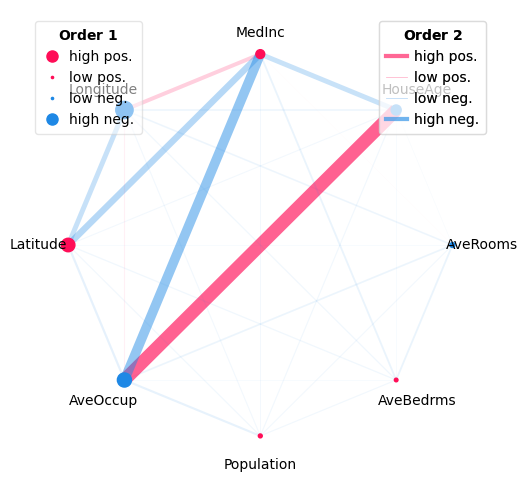

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

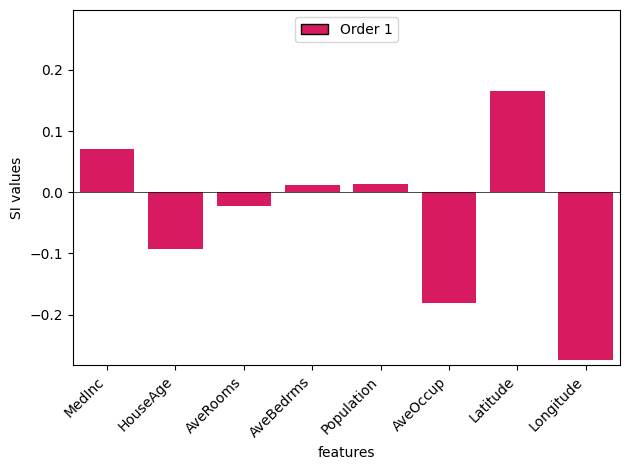

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

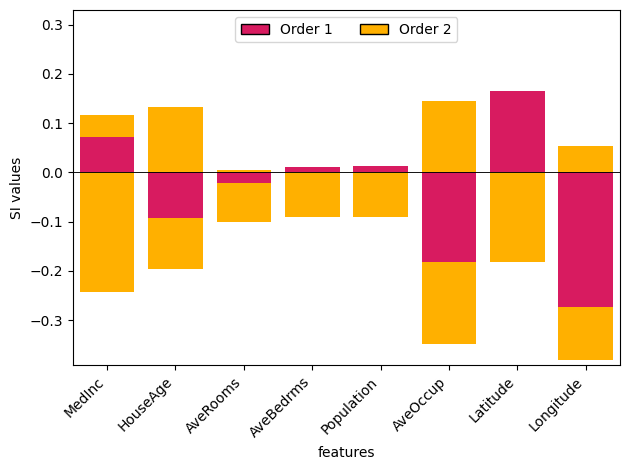

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

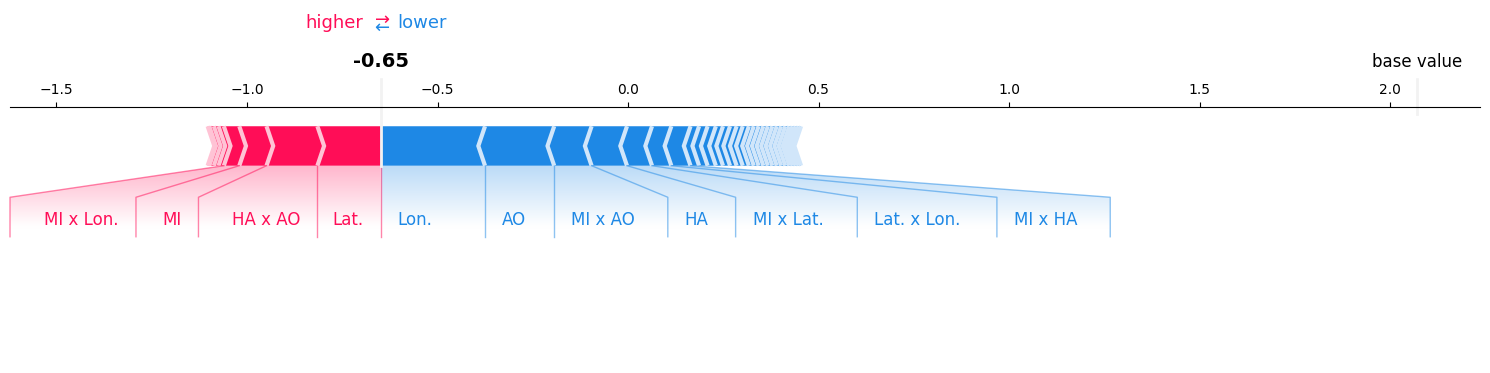

In [13]:
interaction_values.plot_force(feature_names=X.columns)